This script describes the difference between ML and MAM4

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import numpy.ma as ma
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import time

def open_nc(path,scale=1.0):
    ds=(xr.open_dataset(path)*scale)
    ds=ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds=ds.reindex(lon=sorted(ds.lon))  
    return ds

In [2]:
year = "2011"
method_ls = ["MAM4","ML","diff","diff_abs"]
chi_ls = ["chi_b","chi_c","chi_h"]

file_path = {}
file_path["MAM4"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_chi/"
file_path["ML"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/ml_chi/"
file_path["diff"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
file_path["diff_abs"] = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mam4_minus_ml_chi/"
mask_path = "/data/keeling/a/zzheng25/d/mam4_paper_data/chi_only/mask/"

name_ls = {}
name_ls["chi_b"]=r'$\chi_{\rm{o}}$ (%)'
name_ls["chi_c"]=r'$\chi_{\rm{c}}$ (%)'
name_ls["chi_h"]=r'$\chi_{\rm{h}}$ (%)'

char_ls="abcdef"

## hist and scatter for mean

In [3]:
def ax_hist_scatter(chi,idx,ax_title,ax_title_plus_3):
    t0 = time.time()
    mask = open_nc(mask_path+str(year)+"_"+chi+".nc")["mask"]
    MAM4_o = open_nc(file_path["MAM4"]+str(year)+"_"+chi+"_mean.nc",scale=100.0)[chi]\
          .where(mask).to_dataframe()\
          .reset_index().dropna()[chi]
    ML_o = open_nc(file_path["ML"]+str(year)+"_"+chi+"_mean.nc",scale=100.0)[chi]\
          .where(mask).to_dataframe()\
          .reset_index().dropna()[chi]
    diff_o = open_nc(file_path["diff"]+str(year)+"_"+chi+"_mean.nc",scale=100.0)[chi]\
          .where(mask).to_dataframe()\
          .reset_index().dropna()[chi]
    diff_abs = open_nc(file_path["diff_abs"]+str(year)+"_"+chi+"_mean_abs.nc",scale=100.0)[chi]\
          .where(mask).to_dataframe()\
          .reset_index().dropna()[chi]
    del mask 
    gc.collect()
    t1 = time.time()
    print("Finished loading data as dataframe",t1-t0,"s")
    
    MAM4=MAM4_o.rename("MAM4: " + name_ls[chi])
    ML=ML_o.rename("ML: " + name_ls[chi])
    diff = diff_o.rename("diff: " + name_ls[chi])
    diff_abs = diff_abs.rename("diff_abs: " + name_ls[chi])
    t2 = time.time()
    print("Finished renaming and data and calculate the difference",t2-t1,"s")
    
    df = pd.concat([MAM4,ML,diff,diff_abs],axis=1)
    ax = plt.subplot(2,3,idx)
    color_dict={"MAM4: " + name_ls[chi]:"red",
                "ML: " + name_ls[chi]:"orange",
                "diff: " + name_ls[chi]:"blue",
                "diff_abs: " + name_ls[chi]:"purple"}
    t3 = time.time()
    del MAM4, ML, diff
    gc.collect()
    print("Finished concat the dataframe",t3-t2,"s")
    
    ## hist
    col_name_ls = ["MAM4","ML",r"$\Delta\chi$",r"$|\Delta\chi|$"]
    for col_name, col in zip(col_name_ls,df.columns):
        t_t = time.time()
        if chi == "chi_b":
            sns.distplot(df[col],kde=True,
                         color=color_dict[col],
                         label=col_name,
                         ax=ax)
            ax.set_ylabel("density")
        
        elif chi == "chi_c":
            sns.distplot(df[col],kde=True,
                         color=color_dict[col],
                         label=col_name,
                         ax=ax)
            plt.legend(loc="upper left")
        else:
            sns.distplot(df[col],kde=True,
                         color=color_dict[col],
                         label=None,
                         ax=ax)
        ax.set_title(ax_title)
        ax.set_xlabel(name_ls[chi])
        ax.set_xlim(-100,100)
        display(df[col].describe())
        print("Finished",col,time.time()-t_t,"s")
        
    ## scatter
    xedges = list(np.arange(0,100,1))
    yedges = list(np.arange(0,100,1))
    ticks=[0,20,40,60,80,100]
    x=ML_o
    y=MAM4_o

    ax = plt.subplot(2,3,idx+3)
    H, xedges, yedges = np.histogram2d(x,y, bins=(xedges, yedges))
    H = H.T
    H=ma.masked_where(H==0,H)
    X, Y = np.meshgrid(xedges, yedges)
    p = ax.pcolormesh(X, Y, H,
                      norm=colors.LogNorm(vmin=1, vmax=500),edgecolor="face", linewidth=0.00,
                      cmap="plasma_r",rasterized=True)
    ax.plot([0,100], [0,100], 'k--', linewidth = 1)
    ax.set_title(ax_title_plus_3)
    ax.set_xlabel("ML: "+name_ls[chi])
    ax.set_ylabel("MAM4: "+name_ls[chi])
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    plt.xticks([0,25,50,75,100])
    plt.yticks([0,25,50,75,100])
    ax.axvline(x=x.mean(),c='k', ls="--",linewidth = 0.5)
    ax.axhline(y=y.mean(),c='k', ls="--",linewidth = 0.5)
    clb=plt.colorbar(p,orientation='vertical',fraction=0.038,extend='both',ax=ax)
    clb.set_label('num.', labelpad=-10, y=1.1, rotation=0)
    plt.tight_layout()
        
    print("Finished all",time.time()-t0,"s")

chi_b
Finished loading data as dataframe 0.9695556163787842 s
Finished renaming and data and calculate the difference 0.0012874603271484375 s
Finished concat the dataframe 0.04692649841308594 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    37580.000000
mean        86.257466
std         10.537287
min         46.393091
25%         76.748478
50%         90.180416
75%         94.266094
max         99.761359
Name: MAM4: $\chi_{\rm{o}}$ (%), dtype: float64

Finished MAM4: $\chi_{\rm{o}}$ (%) 0.38724517822265625 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    37580.000000
mean        72.548019
std          7.511827
min         54.632290
25%         66.798819
50%         73.038979
75%         77.080269
max         96.163055
Name: ML: $\chi_{\rm{o}}$ (%), dtype: float64

Finished ML: $\chi_{\rm{o}}$ (%) 0.3271467685699463 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    37580.000000
mean        13.709452
std         10.353649
min        -18.863626
25%          7.047183
50%         13.603584
75%         19.399585
max         41.945478
Name: diff: $\chi_{\rm{o}}$ (%), dtype: float64

Finished diff: $\chi_{\rm{o}}$ (%) 0.3365294933319092 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    37580.000000
mean        17.753766
std          6.839440
min          1.754346
25%         13.337091
50%         16.073554
75%         20.735635
max         41.945478
Name: diff_abs: $\chi_{\rm{o}}$ (%), dtype: float64

Finished diff_abs: $\chi_{\rm{o}}$ (%) 0.3263123035430908 s
Finished all 2.952991247177124 s


chi_c
Finished loading data as dataframe 0.9629576206207275 s
Finished renaming and data and calculate the difference 0.0014307498931884766 s
Finished concat the dataframe 0.02301788330078125 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    43815.000000
mean        58.329311
std         29.180096
min          9.234784
25%         32.399699
50%         65.613351
75%         84.904065
max         99.806565
Name: MAM4: $\chi_{\rm{c}}$ (%), dtype: float64

Finished MAM4: $\chi_{\rm{c}}$ (%) 0.346726655960083 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    43815.000000
mean        53.546295
std          7.315084
min         31.301344
25%         49.496231
50%         52.915848
75%         58.172157
max         84.171837
Name: ML: $\chi_{\rm{c}}$ (%), dtype: float64

Finished ML: $\chi_{\rm{c}}$ (%) 0.3308448791503906 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    43815.000000
mean         4.783016
std         26.066370
min        -45.636877
25%        -21.107396
50%          9.917758
75%         27.200894
max         58.567628
Name: diff: $\chi_{\rm{c}}$ (%), dtype: float64

Finished diff: $\chi_{\rm{c}}$ (%) 0.3034193515777588 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    43815.000000
mean        30.213293
std          7.771065
min          5.049897
25%         26.419035
50%         29.514167
75%         35.296243
max         58.653877
Name: diff_abs: $\chi_{\rm{c}}$ (%), dtype: float64

Finished diff_abs: $\chi_{\rm{c}}$ (%) 0.3199148178100586 s
Finished all 2.6490914821624756 s


chi_h
Finished loading data as dataframe 0.6688580513000488 s
Finished renaming and data and calculate the difference 0.0012476444244384766 s
Finished concat the dataframe 0.019113779067993164 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    47720.000000
mean        62.799350
std         28.284623
min         10.250702
25%         39.396943
50%         70.977655
75%         88.101715
max         99.848093
Name: MAM4: $\chi_{\rm{h}}$ (%), dtype: float64

Finished MAM4: $\chi_{\rm{h}}$ (%) 0.33287954330444336 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    47720.000000
mean        58.096554
std         11.019038
min         20.912895
25%         50.066832
50%         57.881466
75%         65.212793
max         80.560425
Name: ML: $\chi_{\rm{h}}$ (%), dtype: float64

Finished ML: $\chi_{\rm{h}}$ (%) 0.359041690826416 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    47720.000000
mean         4.702794
std         35.328766
min        -63.611889
25%        -31.935025
50%         14.425572
75%         32.759934
max         76.114740
Name: diff: $\chi_{\rm{h}}$ (%), dtype: float64

Finished diff: $\chi_{\rm{h}}$ (%) 0.33667874336242676 s


/data/keeling/a/zzheng25/miniconda3/envs/partmc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    47720.000000
mean        38.482661
std         11.684556
min          5.994461
25%         31.113113
50%         37.774875
75%         46.923724
max         76.177119
Name: diff_abs: $\chi_{\rm{h}}$ (%), dtype: float64

Finished diff_abs: $\chi_{\rm{h}}$ (%) 0.34767651557922363 s
Finished all 2.5705759525299072 s




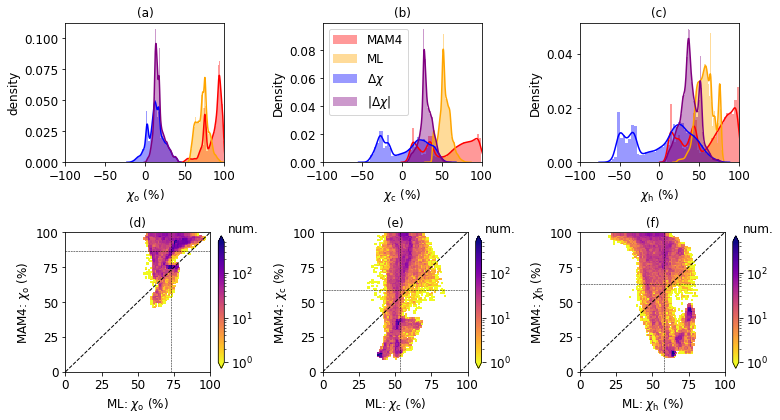

In [4]:
rc={'axes.labelsize':12, 'font.size':12, 'legend.fontsize':12, 'axes.titlesize':12}
plt.rcParams.update(**rc)
fig = plt.figure(figsize=(11,6))
idx=1
for chi in chi_ls:
    print(chi)
    ax_hist_scatter(chi,idx,"("+char_ls[idx-1]+")","("+char_ls[idx+2]+")")
    idx+=1
    print("\n")
plt.tight_layout()
fig.savefig("../figures/hist_scatter.pdf",dpi=288)
plt.show()